IBM-UTokyo 量子コンピューティング・駒場スクール

# 6. 量子機械学習

Kifumi Numata, IBM Quantum, Sep 30 2025 </br>
© 2025 International Business Machines Corporation

Google Colab で行う場合は、次のセルの「#」を削除して実行します。

In [ ]:
#!pip install qiskit qiskit-ibm-runtime qiskit-aer qiskit[visualization]
#!pip install -U scikit-learn

## 1. データの符号化

### 1.1 計算基底符号化
計算基底符号化は、古典の $P$ ビットの文字列を $P$ 量子ビットの計算基底状態に符号化します。
Qiskit では、データ ポイントを符号化する状態を計算したら、`initialize` 関数を使用して準備できます。

$\vec{x} = (5,7,0)$ を符号化してみましょう。これは、2進数表記では、$x_1=101, x_2=111, x_3 = 000$ なので、状態 $|x\rangle= \frac{1}{\sqrt{3}}(|101\rangle+|111\rangle+|000\rangle)$ として符号化されます。

In [1]:
import math
desired_state = [
    1 / math.sqrt(3), # |000>
    0,
    0,
    0,
    0,
    1 / math.sqrt(3), # |101>
    0,
    1 / math.sqrt(3)] # |111>

desired_state

[0.5773502691896258, 0, 0, 0, 0, 0.5773502691896258, 0, 0.5773502691896258]

データを量子状態に直した後は、`initialize` 関数でこの状態を作ることができます。

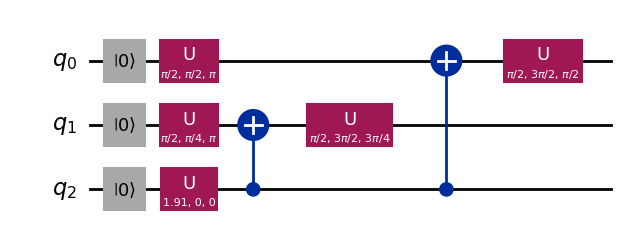

In [2]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3)
qc.initialize(desired_state, [0,1,2])
qc.decompose().decompose().decompose().decompose().decompose().draw(output = 'mpl')

この回路を実行してみましょう。確率振幅はほぼ同じになります。

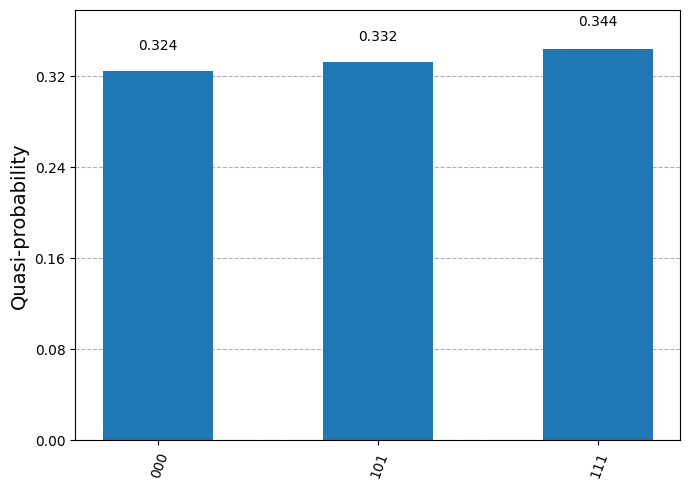

In [3]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_distribution

qc.measure_all()
backend = AerSimulator()
sampler = Sampler(backend)
job = sampler.run([qc])

counts = job.result()[0].data.meas.get_counts()
plot_distribution(counts)    # 結果の分布を表示する

### 1.2 振幅符号化

振幅符号化は、データを量子状態の振幅に符号化します。$\vec{x} = (4,8,5)$を振幅符号化を使用して符号化してみましょう。まず、求めるベクトルを正規化するための定数 $\alpha$ を計算します:

$$\sum_{i=1}^N \left|x_i\right|^2 = 4^2+8^2+5^2 = 105 = \left|\alpha\right|^2 \rightarrow \alpha = \sqrt{105}$$

この定数を使い、計算基底の振幅に順にデータを入れることで量子状態は次のように求められます:

$$|\psi(\vec{x})\rangle = \frac{1}{\sqrt{105}}(4|00\rangle+8|01\rangle+5|10\rangle+0|11\rangle)$$

上記の例では、ベクトル$\vec{x}$の要素の数 $N=3$ は 2 の累乗ではありません。$N$ が 2 の累乗でない場合は、$2^n\geq N$ となる最小の $n$ を量子ビット数とします。残りの振幅ベクトルはゼロで埋めます。今回は $n=2$ が最小の $n$ となるため、 2量子ビットの状態で準備しました。
 
計算基底符号化と同様に、データセットを符号化する状態を計算したら、Qiskit では `initialize` 関数を使用して準備できます。

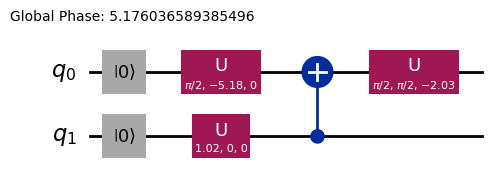

In [4]:
desired_state = [
    1 / math.sqrt(105) * 4,
    1 / math.sqrt(105) * 8,
    1 / math.sqrt(105) * 5,
    1 / math.sqrt(105) * 0]

qc = QuantumCircuit(2)
qc.initialize(desired_state, [0,1])

qc.decompose(reps=5).draw(output = 'mpl')

この量子回路を測定してみましょう。確率振幅にデータが反映されています。

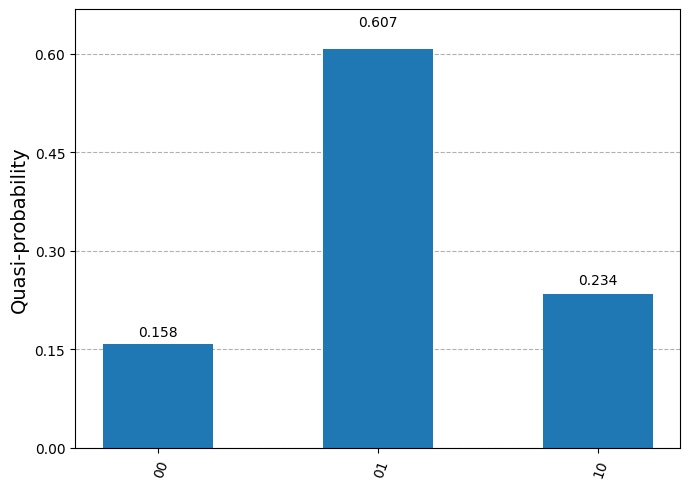

In [5]:
qc.measure_all()
backend = AerSimulator()
sampler = Sampler(backend)
job = sampler.run([qc])

counts = job.result()[0].data.meas.get_counts()
plot_distribution(counts)    # 結果の分布を表示する

### 1.3 角度符号化
角度符号化は、$R_X$ ゲートまたは $R_Y$ ゲートなどの回転ゲートの角度にデータを符号化します。
角度符号化は、量子サポートベクターマシン (QSVM) や変分量子回路 (VQC) などの特徴量マップを使用する QML モデルで重要です。

以下では、$\vec{x}= (0, \pi/4, \pi/2)$ を $R_Y$ ゲートで符号化します。

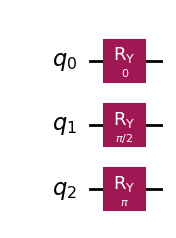

In [6]:
qc = QuantumCircuit(3)
qc.ry(0, 0)
qc.ry(2*math.pi/4, 1)
qc.ry(2*math.pi/2, 2)
qc.draw(output = 'mpl')

### 1.4 角度符号化の応用
角度符号化の応用で、位相の角度にデータを代入し、また、エンタングルメントのための複数量子ビットゲートも含みます。Qiskit の [Circuit Library](https://quantum.cloud.ibm.com/docs/en/api/qiskit/circuit_library) には角度符号化を応用した特徴量マップがあります。

#### Z feature map
[`z_feature_map`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.z_feature_map) (ZFM)は、角度符号化の自然な拡張であるシンプルな特徴量マップです。以下では2次元のデータで3回繰り返しのZFMの回路を作成します。

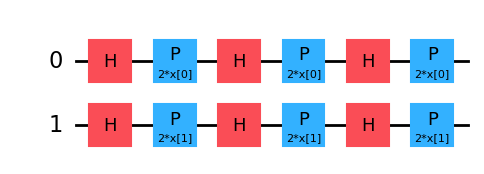

In [7]:
from qiskit.circuit.library import z_feature_map
from math import pi

zfeature_map = z_feature_map(feature_dimension=2, reps=3)
zfeature_map.draw("mpl")

パラメーターにデータを代入するには `assign_parameters` を使います。

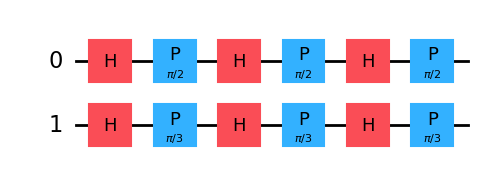

In [8]:
zfeature_map = zfeature_map.assign_parameters([(1/2)*pi/2, (1/2)*pi/3])
zfeature_map.draw("mpl")

#### ZZ feature map
[`zz_feature_map`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.zz_feature_map) (ZZFM) は、2 量子ビットのエンタングル・ゲート、具体的には $ZZ$ 回転ゲート $R_{ZZ}(\theta)$ を追加して ZFM を拡張します。ZZFM は、ZFM とは異なり、古典コンピューターで計算するにはコストがかかると推測されます。以下は、4次元のデータで、エンタングルメントは線形の構造(`linear`)、繰り返しは1回の ZZFM 回路です。

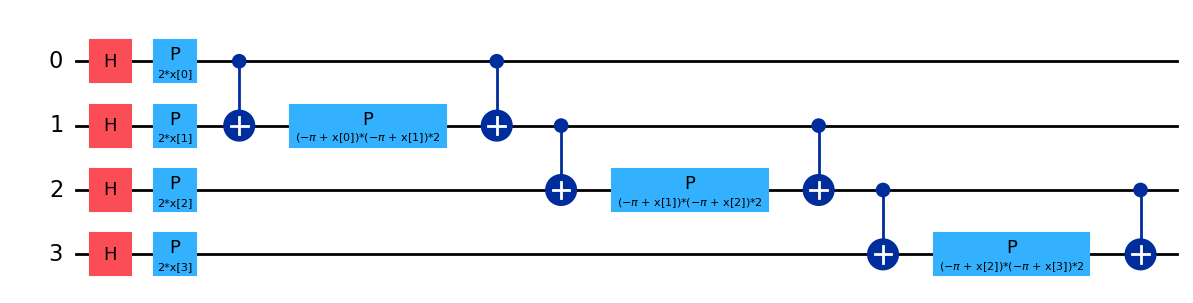

In [9]:
from qiskit.circuit.library import zz_feature_map
 
feature_dim = 4
zzfeature_map = zz_feature_map(
    feature_dimension=feature_dim, entanglement='linear', reps=1
)
zzfeature_map.draw("mpl", scale=1)

#### Pauli feature map

[`pauli_feature_map`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.pauli_feature_map) (PFM) は、任意のパウリ ゲートを使用するために ZFM と ZZFM を一般化したものです。以下は、3次元のデータで、エンタングルメントは線形＋両端の量子ビット対まで対応する`circular`、パウリ演算子は、"X", "YY" の PFM です。

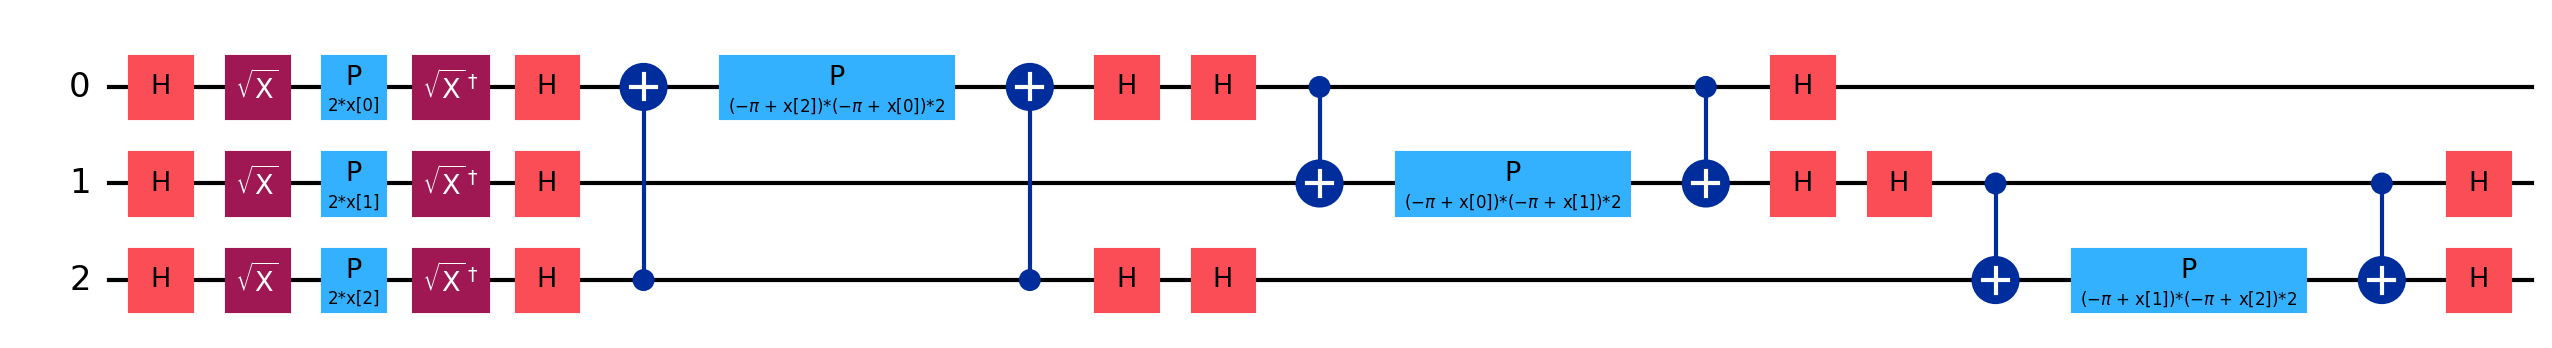

In [10]:
from qiskit.circuit.library import pauli_feature_map
 
feature_dim = 3
pfmap = pauli_feature_map(
    feature_dimension=feature_dim, entanglement='circular', reps=1, paulis=["Y", "XX"]
)
 
pfmap.draw("mpl", scale=1.5)

#### efficient_su2
パラメーター付き回路を特徴量マップとして用いることもできます。以下は、エンタングルメントを使用した符号化の一般的で有用な例である、 [`efficient_su2`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.efficient_su2) 回路です。この回路は、たとえば 2 量子ビットだけで 8 つの特徴を符号化できます。

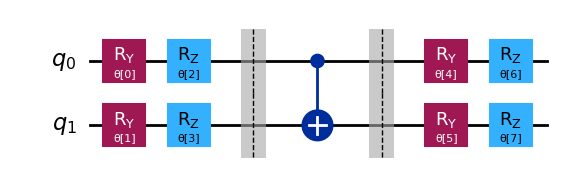

In [11]:
from qiskit.circuit.library import efficient_su2
 
circuit = efficient_su2(num_qubits=2, reps=1, insert_barriers=True)
circuit.draw(output="mpl")

## 2. 手書き文字の学習
### データを用意

ここでは，手書き数字画像のデータセット(MNISTデータセット)から0と1のサブセットを扱います。

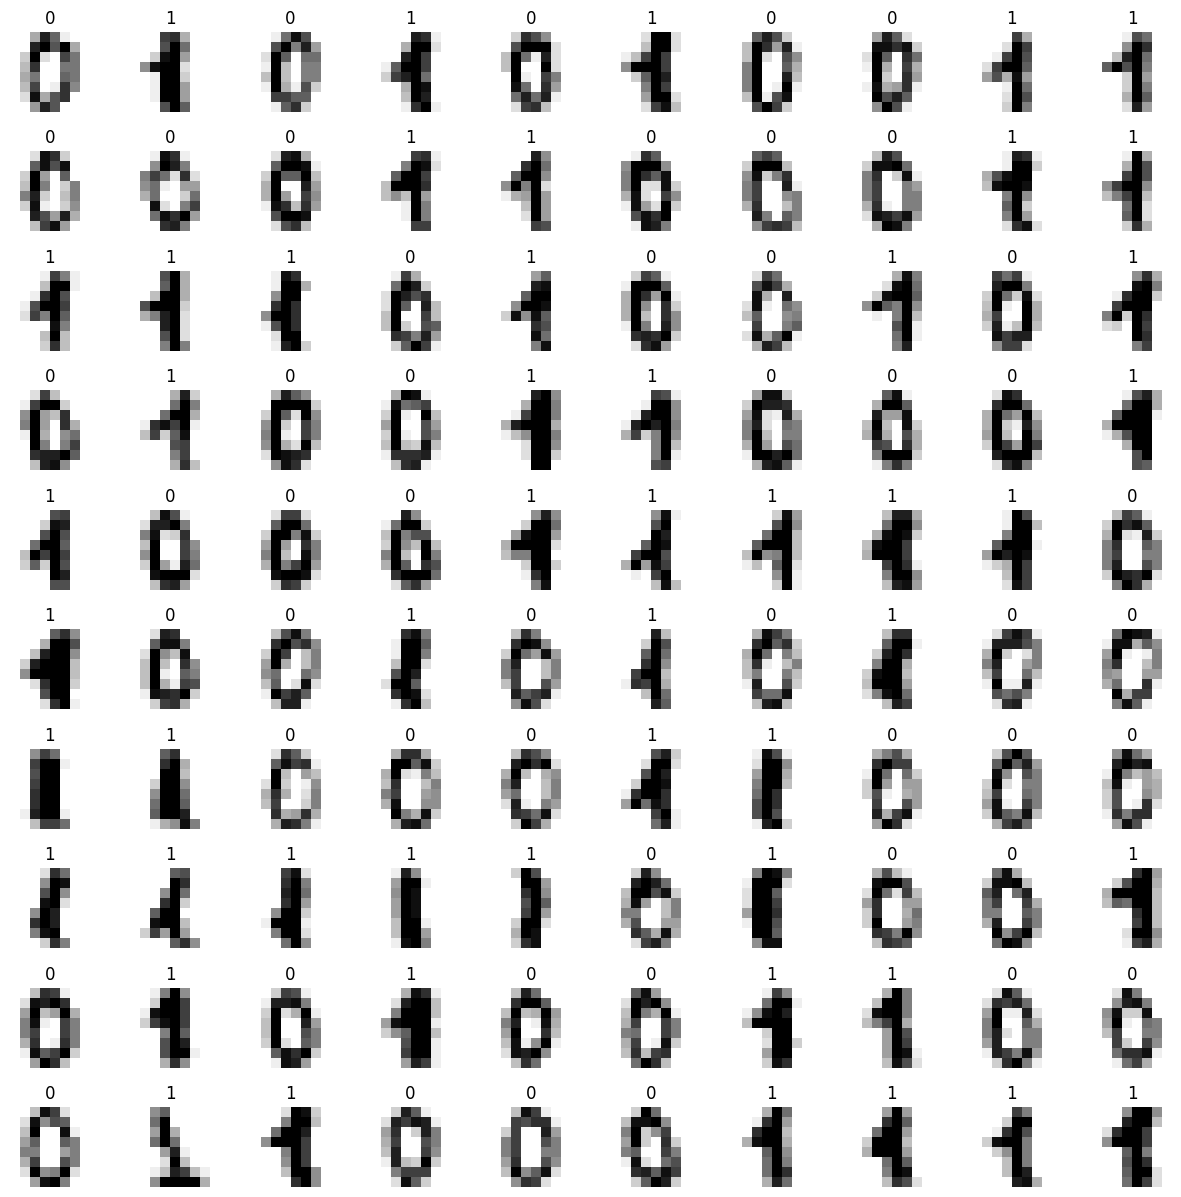

In [12]:
# Scikit-learnのインポート(Python用の機械学習ライブラリー)
from sklearn import datasets

# 描画のため
import matplotlib.pyplot as plt

# 数字データセットから2クラスのデータ(0と1)を読み込み
digits = datasets.load_digits(n_class=2)   

# 読み込んだ画像の最初の100枚をプロット
fig, axes = plt.subplots(10, 10, figsize=(15, 15), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.5, wspace=0.5))
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(digits.target[i])

In [13]:
print(digits.images[0])

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


このデータセットには、合計360個のデータが含まれています。各データポイントは、8×8の数字の画像で、配列になっていて、各要素は0（白）から16（黒）までの整数です。古典的な分類アルゴリズムの際と同様に、データセットを学習用（25個）とテスト用（10個）のサンプルに分割し、正規化する必要があります。このデータセットを量子分類アルゴリズムに用いるために、範囲を-1から1の間にスケーリングし、次元を使用する量子ビット数（今回は4）に縮小します。

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split # データ分割
from sklearn.decomposition import PCA # Principal component analysis(主成分分析)
from sklearn.preprocessing import StandardScaler, MinMaxScaler # 標準化、正規化のスケール変換

# データセットの分割
sample_train, sample_test, labels_train, labels_test = train_test_split(
     digits.data, digits.target, test_size=0.4, random_state=22)

# 次元削除
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# 正規化
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# スケーリング
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# 学習用25個とテスト用10個を選択
train_size = 25
sample_train = sample_train[:train_size]
labels_train = labels_train[:train_size]

test_size = 10
sample_test = sample_test[:test_size]
labels_test = labels_test[:test_size]

In [15]:
# 一つ目のデータをそれぞれ表示
print(sample_train[0], labels_train[0])
print(sample_test[0], labels_test[0])

[-0.84125996  0.08883315 -0.41289909 -0.08403989] 0
[0.41456664 0.7486731  0.74168091 0.32496914] 1


In [16]:
# 学習用データのラベルを表示
print(labels_train)

[0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1]


## データ符号化(エンコード)

この古典データを、量子特徴量マップ(`zz_feature_map`)を用いて量子状態空間にエンコードしていきます。

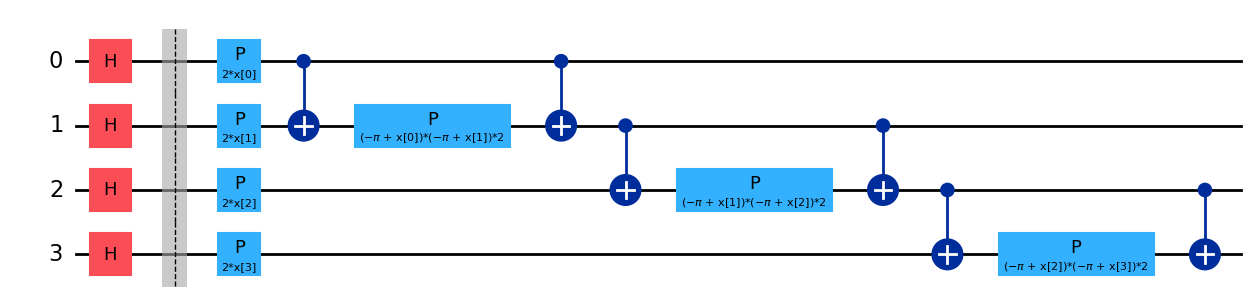

In [17]:
# 4特徴量、深さ(繰り返し数)1のZZFeatureMap
zz_map = zz_feature_map(feature_dimension=4, entanglement='linear', reps=1, insert_barriers=True)
zz_map.draw('mpl')

### 量子カーネルの計算

`zz_feature_map`を使って、学習データの0個目と1個目のデータについて、量子カーネルを計算する量子回路を作成し、実際に計算してみます。この値は、二つの量子状態のFidelity(忠実度)ともいいます。

In [18]:
print(sample_train[0])
print(sample_train[1])

[-0.84125996  0.08883315 -0.41289909 -0.08403989]
[-0.63560347  0.29571254 -0.49227085  0.39130638]


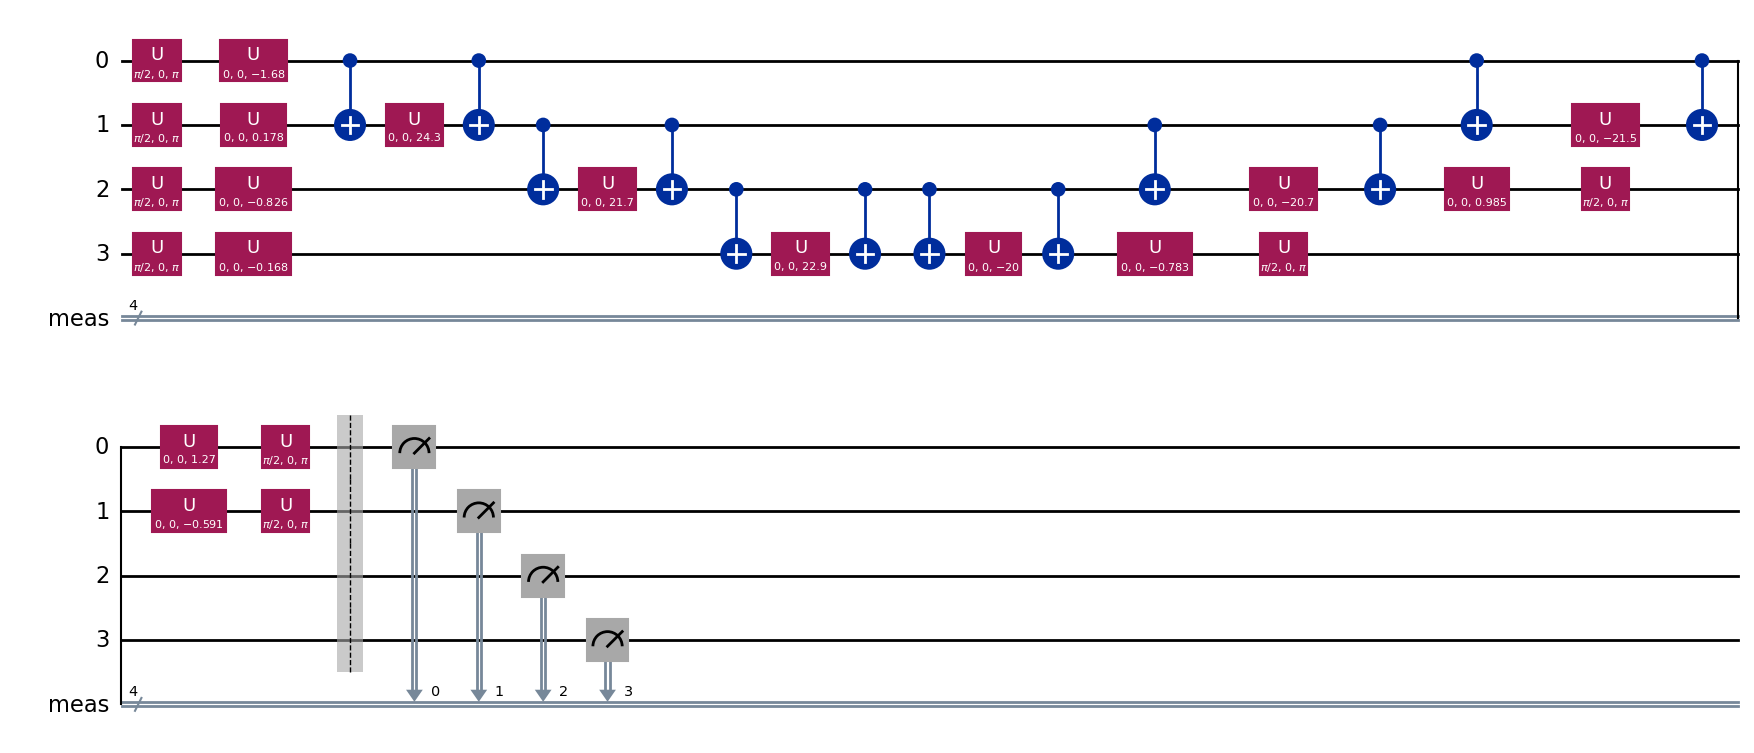

In [19]:
zz_map = zz_feature_map(feature_dimension=4, reps=1, entanglement='linear')
qc_1 =zz_map.assign_parameters(sample_train[0])
qc_2 =zz_map.assign_parameters(sample_train[1])
fidelity_circuit = qc_1.copy()
fidelity_circuit.append(qc_2.inverse().decompose(), range(fidelity_circuit.num_qubits))
fidelity_circuit.measure_all()
fidelity_circuit.decompose().draw('mpl')

各回転ゲートのパラメーター値は少し読みにくいですが、回路が対称になっていることが分かると思います。左半分は学習データsample_train[0]が、右半分は学習データsample_train[1]がコード化されています。

例として、上記の量子カーネルを測定し、ゼロ状態のカウント数の割合として、カーネル行列の要素（訓練データの0個目と1個目のデータについて）を計算します。

In [20]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# シミュレーターで実験
backend = AerSimulator()
# 回路を最適化
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(fidelity_circuit)

In [21]:
# Samplerで実行
nshots = 1024
sampler = Sampler(backend)
job = sampler.run([isa_qc], shots=nshots)
result = job.result()

#  測定された回数を表示
counts = result[0].data.meas.get_counts()
print(counts)

{'1111': 536, '0101': 5, '0111': 167, '1001': 178, '0001': 40, '1101': 35, '1000': 10, '1110': 14, '1011': 3, '0011': 6, '1010': 3, '0110': 7, '0000': 4, '0010': 2, '0100': 6, '1100': 8}


In [22]:
counts.get('0000')/sum(counts.values())

0.00390625

### 量子カーネル計算

このプロセスを，学習データサンプルのペアごとに繰り返して学習カーネル行列を埋めていきます。
先ほどど同じ `zz_feature_map` を用いて量子回路を作り、また、今回は、 `unitary_overlap`を使ってカーネル行列の要素となるfidelityを計算します。

In [23]:
from qiskit.circuit.library import unitary_overlap
zz_map = zz_feature_map(feature_dimension=4, reps=1, entanglement='linear')
fidelity = unitary_overlap(zz_map, zz_map)
fidelity.measure_all()

回路の形状を見てみましょう。

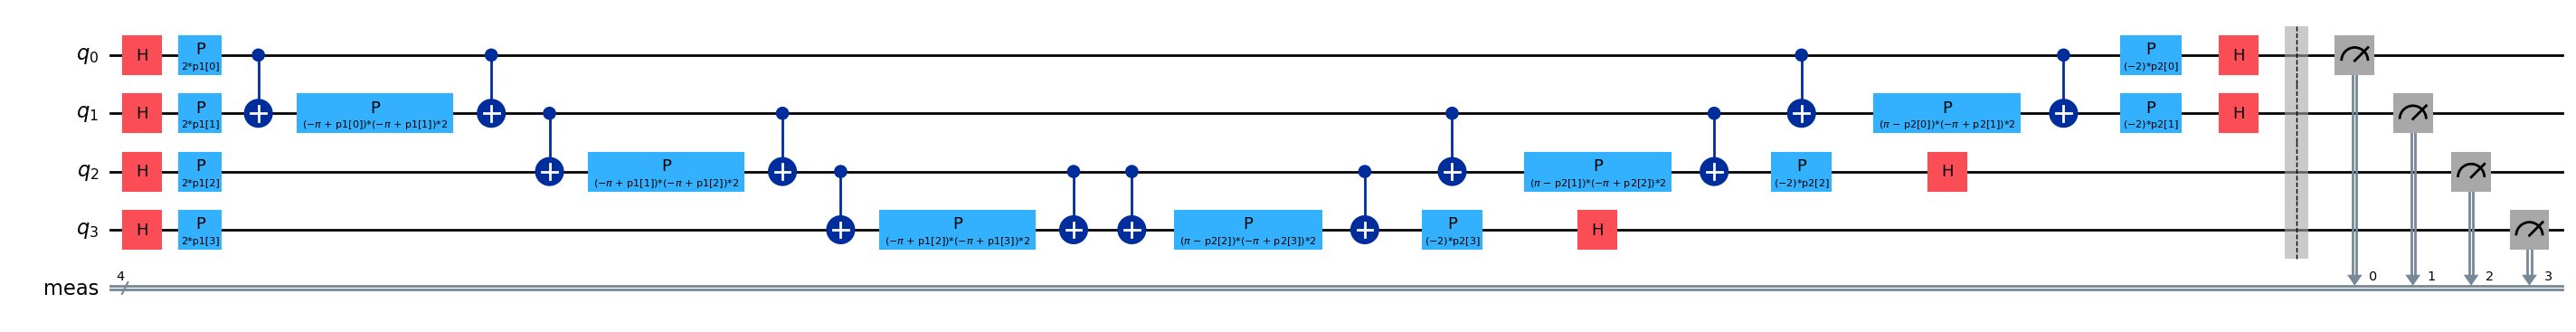

In [24]:
fidelity.draw('mpl', idle_wires=False, fold=-1)

出力を格納するために、空のカーネル行列と、次元の空のテスト用カーネル行列を作ります。

In [25]:
# 空のカーネル行列
kernel_matrix = np.full((train_size, train_size), np.nan) # 25x25の学習用カーネル行列
test_matrix = np.full((test_size, train_size), np.nan) # 10x25のテスト用カーネル行列

Overlap回路を作ります。カーネル行列は対角に対して対称なので、同じ計算は繰り返さないようにすることで、計算回数は二分の一に減らせます。また、ノイズがない場合は対角要素が1となるため、今回は対角要素を計算せず、1を代入します。(25×25×1/2-25)要素と(10×25)要素を計算するので、以下のセルは実行にすこし時間がかかるかもしれません。

In [26]:
%%time
num_shots = 1024

backend = AerSimulator()
sampler = Sampler(mode=backend)

for x1 in range(0,train_size):
    for x2 in range(x1+1,train_size):
        unitary1 = zz_map.assign_parameters(list(sample_train[x1]))
        unitary2 = zz_map.assign_parameters(list(sample_train[x2]))

        # Overlap回路の作成
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
    
        # Qiskit sampler primitiveの実行
        counts = (sampler.run([overlap_circ], shots=num_shots).result()[0].data.meas.get_int_counts())

        # |0>状態の確率をカーネル行列の要素に入れ、転置された要素にも同じ確率を入れます。
        kernel_matrix[x1, x2] = counts.get(0, 0.0)/num_shots
        kernel_matrix[x2, x1] = counts.get(0, 0.0)/num_shots
    # 確率の内積なので、対角線上の要素を1で埋めます
    kernel_matrix[x1,x1] =1    

print("training done")

# 上記と同様のプロセスをテストデータを使って行う
for x1 in range(0,test_size):
    for x2 in range(0,train_size):
        unitary1 = zz_map.assign_parameters(list(sample_test[x1]))
        unitary2 = zz_map.assign_parameters(list(sample_train[x2]))

        # Overlap回路の作成
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
    
        counts = (sampler.run([overlap_circ], shots=num_shots).result()[0].data.meas.get_int_counts())

        test_matrix[x1, x2] = counts.get(0, 0.0)/num_shots

print("test matrix done")

training done
test matrix done
CPU times: user 8.73 s, sys: 3.36 s, total: 12.1 s
Wall time: 1.77 s


2つのカーネル行列を見てみましょう。

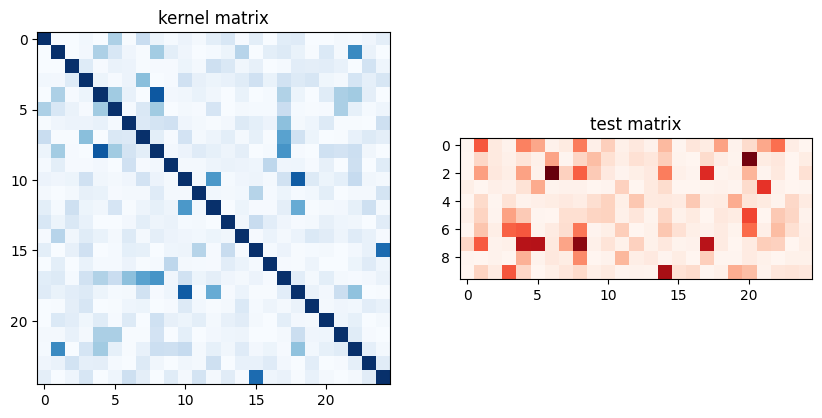

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(kernel_matrix),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("kernel matrix")
axs[1].imshow(np.asmatrix(test_matrix),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("test matrix")
plt.show()

### 古典計算による学習

古典の機械学習アルゴリズムで学習を行います。Scikit-Learnのサポートベクトル分類器（SVC）`sklearn.svc`を使い、事前に計算したカーネルを使うため、`kernel = precomputed` を指定します。

In [28]:
from sklearn.svm import SVC # SVM Classification(SVM分類)

# 古典の機械学習パッケージからサポートベクトル分類器で事前に計算されたカーネル行列を使用することを指定
qml_svc = SVC(kernel="precomputed")

`SVC.fit` を使って、カーネル行列と学習用ラベルを入力し、学習します。`SVC.predict` は test_matrix を使ってテストデータのラベルを予測します。`SVC.score` はテストデータをスコアリングして精度を返します。

In [29]:
# 事前に計算された行列と学習データのラベルを入力。古典アルゴリズムがfitを行います。
qml_svc.fit(kernel_matrix, labels_train)

# 学習データとテストデータのカーネル行列を用いてテストデータのラベルを予測します。
label_predict = qml_svc.predict(test_matrix)
print(label_predict, labels_test, sep="\n")

# テストデータの行列とテストラベルを入力として、.scoreを使ってデータをテストします。
qml_score_precomputed_kernel = qml_svc.score(test_matrix, labels_test)
print(f"Precomputed kernel classification test score: {qml_score_precomputed_kernel}")

[0 1 0 1 1 1 0 0 1 0]
[1 1 0 1 1 1 0 0 1 0]
Precomputed kernel classification test score: 0.9


90%の確率で学習されました。

## 演習 1
[`pauli_feature_map`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.pauli_feature_map) を使って、独自の特徴量マップを作成し、同じデータセットでカーネル行列を作り、学習精度を向上させてみてください。

In [ ]:
feature_dim = ##記入してください##
p_map = pauli_feature_map(
    ##記入してください##
)
p_map.draw("mpl", scale=1.5)

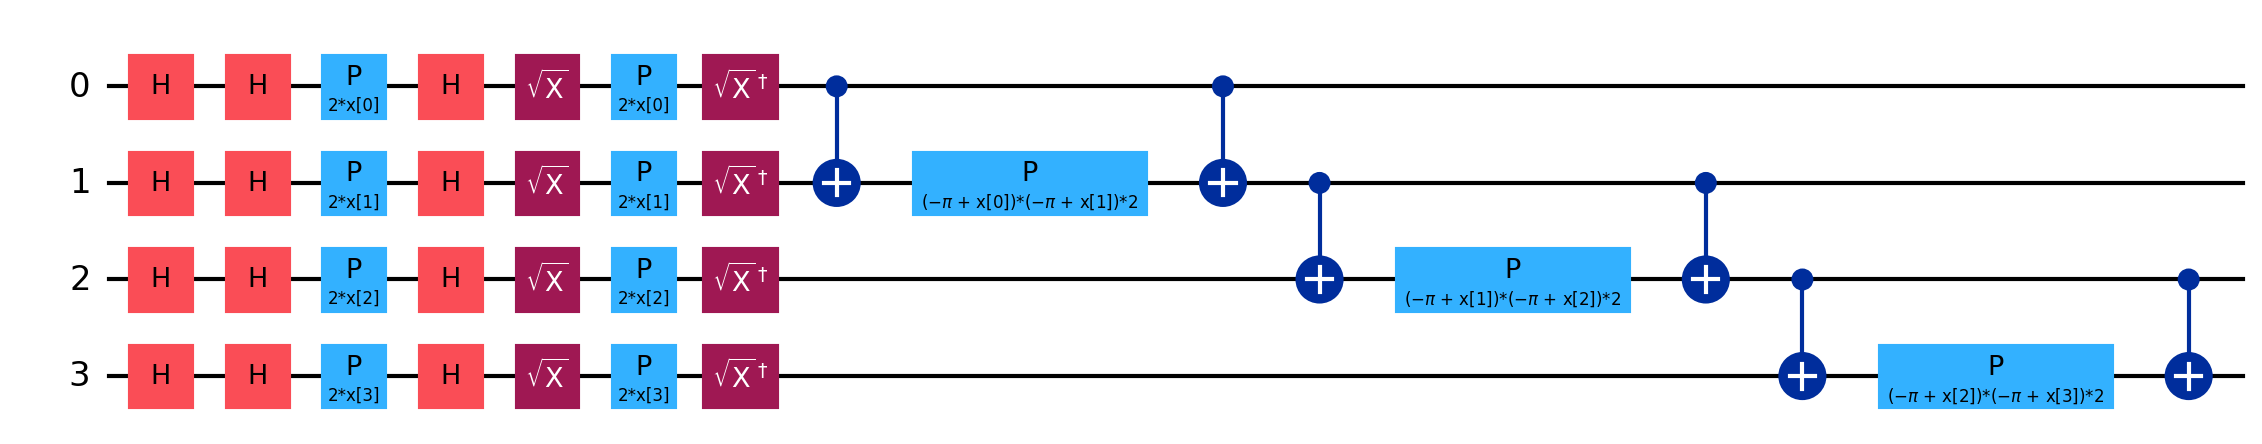

In [30]:
## 解答例 ##
feature_dim = 4
p_map = pauli_feature_map(
    feature_dimension=feature_dim, entanglement='linear', reps=1, paulis=["X", "Y", "ZZ"]
)
 
p_map.draw("mpl", scale=1.5)

In [31]:
# 空のカーネル行列
kernel_matrix_ex1 = np.full((train_size, train_size), np.nan) # 25x25の学習用カーネル行列
test_matrix_ex1 = np.full((test_size, train_size), np.nan) # 10x25のテスト用カーネル行列

In [32]:
%%time
num_shots = 1024

backend = AerSimulator()
sampler = Sampler(mode=backend)

for x1 in range(0,train_size):
    for x2 in range(x1+1,train_size):
        unitary1 = p_map.assign_parameters(list(sample_train[x1]))
        unitary2 = p_map.assign_parameters(list(sample_train[x2]))

        # Overlap回路の作成
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
    
        # Qiskit sampler primitiveの実行
        counts = (sampler.run([overlap_circ], shots=num_shots).result()[0].data.meas.get_int_counts())

        # |0>状態の確率をカーネル行列の要素に入れ、転置された要素にも同じ確率を入れます。
        kernel_matrix_ex1[x1, x2] = counts.get(0, 0.0)/num_shots
        kernel_matrix_ex1[x2, x1] = counts.get(0, 0.0)/num_shots
    # 確率の内積なので、対角線上の要素を1で埋めます
    kernel_matrix_ex1[x1,x1] =1    

print("training done")

# 上記と同様のプロセスをテストデータを使って行う
for x1 in range(0,test_size):
    for x2 in range(0,train_size):
        unitary1 = p_map.assign_parameters(list(sample_test[x1]))
        unitary2 = p_map.assign_parameters(list(sample_train[x2]))

        # Overlap回路の作成
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
    
        counts = (sampler.run([overlap_circ], shots=num_shots).result()[0].data.meas.get_int_counts())

        test_matrix_ex1[x1, x2] = counts.get(0, 0.0)/num_shots

print("test matrix done")

training done
test matrix done
CPU times: user 10.2 s, sys: 3.87 s, total: 14 s
Wall time: 1.9 s


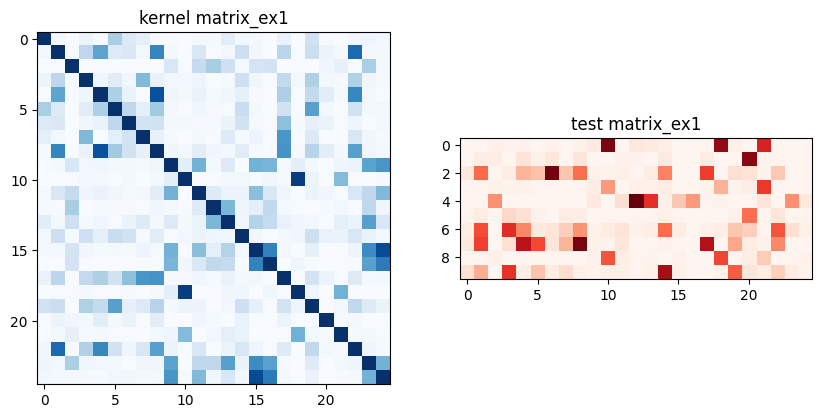

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(kernel_matrix_ex1),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("kernel matrix_ex1")
axs[1].imshow(np.asmatrix(test_matrix_ex1),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("test matrix_ex1")
plt.show()

In [34]:
# 古典の機械学習パッケージからサポートベクトル分類器で事前に計算されたカーネル行列を使用することを指定
qml_svc = SVC(kernel="precomputed")

# 事前に計算された行列と学習データのラベルを入力。古典アルゴリズムがfitを行います。
qml_svc.fit(kernel_matrix_ex1, labels_train)

# 学習データとテストデータのカーネル行列を用いてテストデータのラベルを予測します。
label_predict_ex1 = qml_svc.predict(test_matrix_ex1)
print(label_predict_ex1, labels_test, sep="\n")

# テストデータの行列とテストラベルを入力として、.scoreを使ってデータをテストします。
qml_score_precomputed_kernel = qml_svc.score(test_matrix_ex1, labels_test)
print(f"Precomputed kernel classification test score: {qml_score_precomputed_kernel}")

[1 1 0 1 1 1 0 0 1 0]
[1 1 0 1 1 1 0 0 1 0]
Precomputed kernel classification test score: 1.0


## 3. 洋服画像データの分類


ここで扱うデータは，MNISTデータセットの亜種である[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist/blob/master/README.ja.md)という洋服画像データセットのサブセットです。


![Fashion-MNIST](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/refs/heads/master/doc/img/fashion-mnist-sprite.png)


以下のラベルの画像について分類します。

- label 2: プルオーバー
- label 3: ドレス

まずデータセットを読み込んで，クラスごとに1枚ずつ画像を表示してみます。

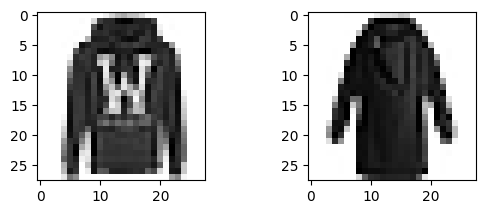

In [35]:
# データのロード
DATA_PATH = 'fashion.npz'
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']
sample_test = data['sample_test']

# データセットの分割
sample_train, sample_test, labels_train, labels_test = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

# データの表示
fig = plt.figure()
LABELS = [2,3]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(2, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

次に，以下のデータセットの前処理をします

- 主成分分析(PCA)による次元圧縮
- 正規化
- スケーリング
- 学習用（50個）とテスト用（10個）のサンプルを選択


In [36]:
# 次元削除
N_DIM = 5
pca = PCA(n_components=N_DIM).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# 正規化
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# スケーリング
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# 選択
train_size = 50
sample_train = sample_train[:train_size]
labels_train = labels_train[:train_size]

test_size = 10
sample_test = sample_test[:test_size]
labels_test = labels_test[:test_size]

In [37]:
# 一つ目のデータをそれぞれ表示
print(sample_train[0], labels_train[0])
print(sample_test[0], labels_test[0])

[ 0.6363233   0.2027854  -0.20199092  0.61951941  0.23576294] 2
[-0.21931836  1.         -0.08839213  0.08616992 -0.19730241] 3


## 演習 2

この洋服画像データについて、自由にカーネル行列を設計し、古典のSVMを使って学習してください。学習率を確認してみましょう。

In [ ]:
fmap_ex2 =

fmap_ex2.decompose().draw('mpl', idle_wires=False, fold=-1)

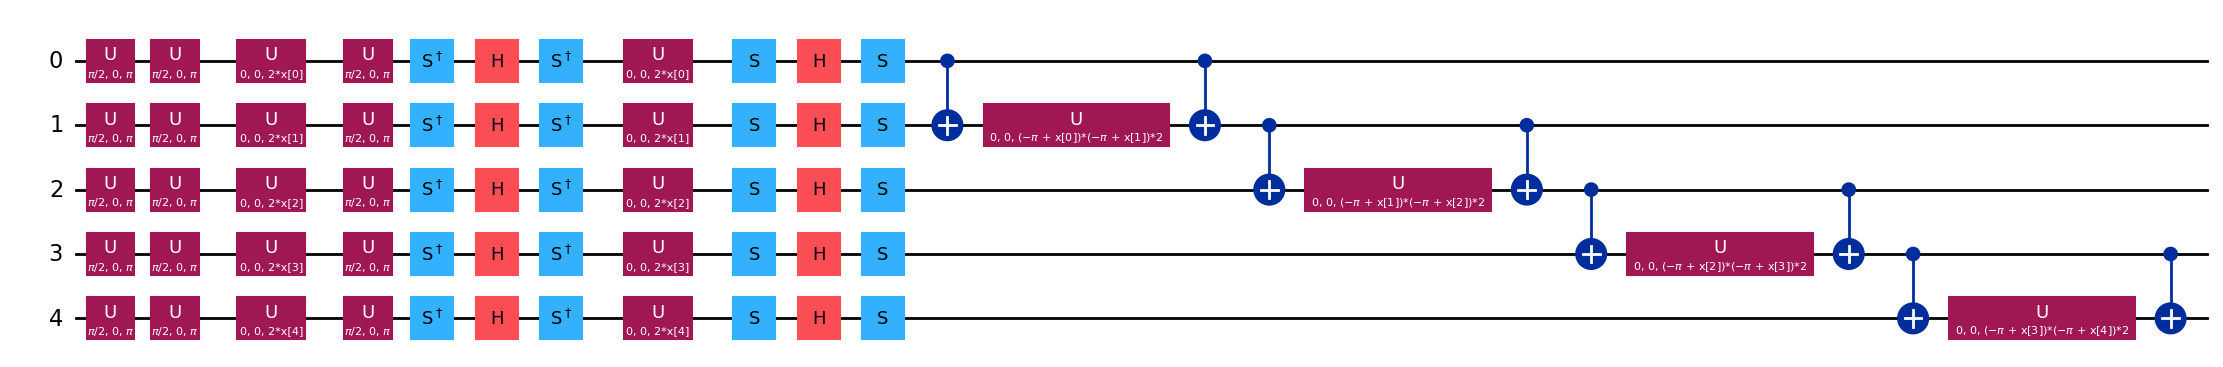

In [38]:
##解答例##
fmap_ex2 = pauli_feature_map(
    feature_dimension=5, entanglement='linear', reps=1, paulis=["X", "Y", "ZZ"]
)
fmap_ex2.decompose().draw('mpl', idle_wires=False, fold=-1)

In [39]:
# 空のカーネル行列
kernel_matrix_ex2 = np.full((train_size, train_size), np.nan) # 50x50の学習用カーネル行列
test_matrix_ex2 = np.full((test_size, train_size), np.nan) # 10x50のテスト用カーネル行列

カーネル行列を計算します。

In [40]:
%%time
num_shots = 1024

backend = AerSimulator()
sampler = Sampler(mode=backend)

for x1 in range(0,train_size):
    for x2 in range(x1+1,train_size):
        unitary1 = fmap_ex2.assign_parameters(list(sample_train[x1]))
        unitary2 = fmap_ex2.assign_parameters(list(sample_train[x2]))

        # Overlap回路の作成
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
    
        # Qiskit sampler primitiveの実行
        counts = (
            sampler.run([overlap_circ], shots=num_shots).result()[0].data.meas.get_int_counts()
        )

        # |0>状態の確率をカーネル行列の要素に入れ、転置された要素にも同じ確率を入れます。
        kernel_matrix_ex2[x1, x2] = counts.get(0, 0.0)/num_shots
        kernel_matrix_ex2[x2, x1] = counts.get(0, 0.0)/num_shots
    # 確率の内積なので、対角線上の要素を1で埋めます
    kernel_matrix_ex2[x1,x1] =1    

print("training done")

# 上記と同様のプロセスをテストデータを使って行う
for x1 in range(0,test_size):
    for x2 in range(0,train_size):
        unitary1 = fmap_ex2.assign_parameters(list(sample_test[x1]))
        unitary2 = fmap_ex2.assign_parameters(list(sample_train[x2]))

        # Overlap回路の作成
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
    
        counts = (
            sampler.run([overlap_circ], shots=num_shots).result()[0].data.meas.get_int_counts()
        )

        test_matrix_ex2[x1, x2] = counts.get(0, 0.0)/num_shots

print("test matrix done")

training done
test matrix done
CPU times: user 33.8 s, sys: 12.6 s, total: 46.4 s
Wall time: 6.21 s


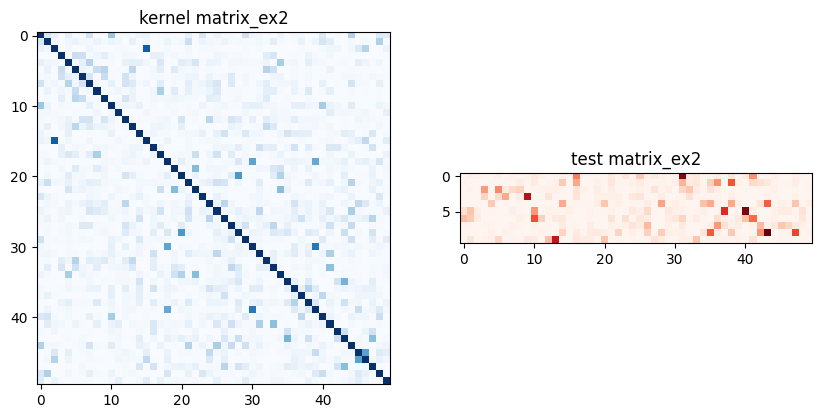

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(kernel_matrix_ex2),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("kernel matrix_ex2")
axs[1].imshow(np.asmatrix(test_matrix_ex2),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("test matrix_ex2")
plt.show()

In [42]:
# 古典の機械学習パッケージからサポートベクトル分類器で事前に計算されたカーネル行列を使用することを指定
qml_svc = SVC(kernel="precomputed")

# 事前に計算された行列と学習データのラベルを入力。古典アルゴリズムがfitを行います。
qml_svc.fit(kernel_matrix_ex2, labels_train)

# 学習データとテストデータのカーネル行列を用いてテストデータのラベルを予測します。
label_predict = qml_svc.predict(test_matrix_ex2)
print(label_predict, labels_test, sep="\n")

# テストデータの行列とテストラベルを入力として、.scoreを使ってデータをテストします。
qml_score_precomputed_kernel = qml_svc.score(test_matrix_ex2, labels_test)
print(f"Precomputed kernel classification test score: {qml_score_precomputed_kernel}")

[3 3 3 3 2 2 2 2 2 3]
[3 3 3 3 2 2 2 2 2 3]
Precomputed kernel classification test score: 1.0


## 時間の余った方向け

データセットunknown_dataが プルオーバー（ラベル2）、またはドレス（ラベル3）、どちらのデータセットであるかを学習した量子カーネル行列を使って、SVMで判別してください。データunknown_dataは、10個の同じラベルのデータセットを次元削除、正規化、スケーリングしたものです。

In [43]:
unknown_data = [
    [0.31559114, -0.22212598, -0.01367075, 0.26984272, 0.09538095],
    [0.61950235, 0.11437916, -0.71187257, -0.20481753, 0.33026303],
    [0.81223033, 0.16992666, 0.01845638, 0.03393138, 0.05011245],
    [0.84295123, 0.07871908, -0.73484067, 0.05868912, 0.11878952],
    [0.88399294, 0.05947462, -0.44905742, -0.41026581, -0.19594553],
    [0.77159032, 0.19355832, 0.49900056, -1.0, -0.09096834],
    [0.06948713, -0.5180201, 0.45473245, -0.02749577, -0.38410395],
    [1.0, 0.20637581, -0.24059816, 0.24122204, 0.28130522],
    [-0.13116065, -0.06375504, -0.1368573, 0.8475517, -0.01036726],
    [-0.37941815, -0.76067967, -0.22019796, 0.17362436, -0.23302668]
]

In [44]:
# 空のカーネル行列
test_matrix_3 = np.full((test_size, train_size), np.nan) # 10x30のテスト用カーネル行列

In [45]:
%%time
### Solution ###
# 学習データとunknown_dataデータとのカーネル行列(30x10)を計算します
for x1 in range(0,test_size):
    for x2 in range(0,train_size):
        unitary1 = fmap_ex2.assign_parameters(list(unknown_data[x1]))
        unitary2 = fmap_ex2.assign_parameters(list(sample_train[x2]))

        # Overlap回路の作成
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
    
        counts = (sampler.run([overlap_circ], shots=num_shots).result()[0].data.meas.get_int_counts())

        test_matrix_3[x1, x2] = counts.get(0, 0.0)/num_shots

print("test matrix done")

test matrix done
CPU times: user 10.2 s, sys: 3.76 s, total: 14 s
Wall time: 1.92 s


In [46]:
label_predict = qml_svc.predict(test_matrix_3)
print(label_predict)

[2 2 2 2 2 2 2 2 3 2]


In [47]:
import qiskit
qiskit.__version__

'2.2.0'